#  Detection of wind outages over W Europe and link with weather regime

In [1]:
import netCDF4
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.ticker import FixedLocator

import pandas as pd

import datetime

## Getting wind speed over land using CDO

Computing wind speed norm from u and v components then selecting data over land

## Opening data and preparing domain

In [91]:
ws = xr.open_dataset('./data/wind10_eur_19790101_20191231_LAND.nc')

In [92]:
lat  = ws.latitude.values
lon  = ws.longitude.values
latS=30
latN=80
lonW=-20
lonE=30
projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)
bounds = [(lonW, lonE, latS, latN)]

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

## Preliminary data visualisation

Seaosonal average wind speed plot

In [4]:
ws_season = ws.groupby('time.season').mean('time')

In [5]:
wind_levels = np.linspace(0,8,17)

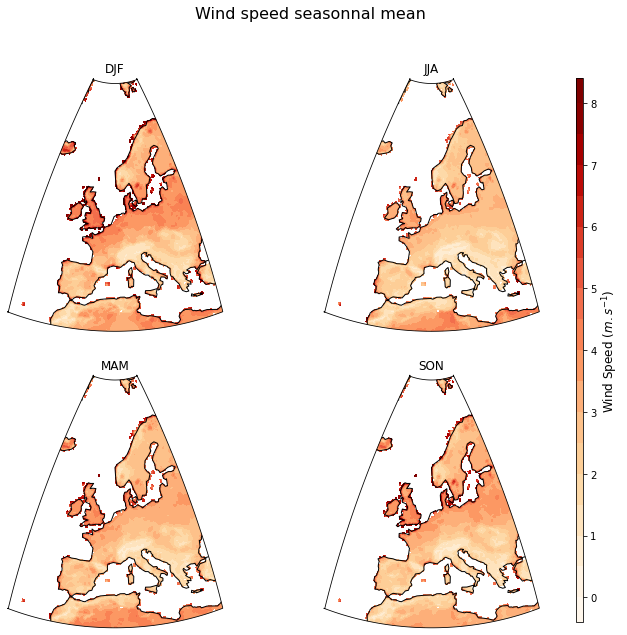

In [6]:
fig = plt.figure(figsize=(13, 10))

plt.suptitle('Wind speed seasonnal mean', fontsize=16)
for i, season in enumerate(ws_season.season) :
    ax = fig.add_subplot(2, 2, i+1, projection=projection)
    ax.coastlines()
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lon, lat)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, ws_season.ws.sel(season = season), levels = wind_levels,
                     cmap='OrRd', extend='both', transform=ccrs.PlateCarree())
    ax.set_title(season.values)
    
cb = fig.colorbar(cf, ax = fig.axes, orientation='vertical', aspect=65, extendrect='True')
cb.set_label('Wind Speed ($m.s^{-1}$)', fontsize=12)

=================================================================================================================

Spatial variations of temporal variance

In [95]:
ws_temp_var = ws.ws.std('time')

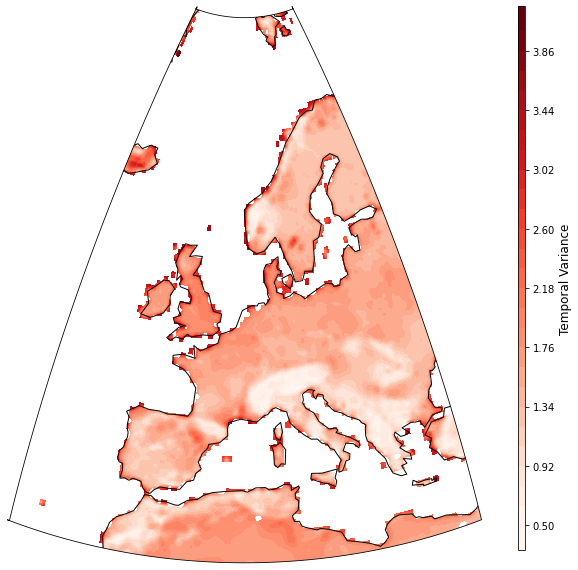

In [96]:
fig = plt.figure(figsize=(13, 10))

ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, ws_temp_var, levels = np.linspace(0.5,4,26),
                 cmap='Reds', extend='both', transform=ccrs.PlateCarree())
    
cb = fig.colorbar(cf, ax = fig.axes, orientation='vertical', aspect=65, extendrect='True')
cb.set_label('Temporal Variance', fontsize=12)

# Wind outage detection using Wind Speed Index (WSI) over western Europe

In this section we define WSI wich should be a number representative of current wind speed condition over an area.

Then we need to define a smaller area more representative of western Europe. (knowing that wind data has been filtered and are available only over land)
+ note : does not take wind turbine density into account
    + rapid research : no easy data, <b> remember to ask <b/>

In [98]:
#WSI AREA
latS_zoom=37
latN_zoom=60
lonW_zoom=-10
lonE_zoom=25
hres = 0.25 #degree
zoom_bounds = [(lonW_zoom, lonE_zoom, latS_zoom, latN_zoom)]
lon_zoom = np.arange(lonW_zoom,lonE_zoom+hres,hres)
lat_zoom = np.arange(latS_zoom,latN_zoom+hres,hres)

In [99]:
#better x ticks
def dayofyear_todate(dayofyear) :
    offset_bisextyear = 3*365
    return f'{datetime.date.fromordinal(offset_bisextyear + dayofyear).day:02d}/{datetime.date.fromordinal(offset_bisextyear + dayofyear).month:02d}'
dates = [dayofyear_todate(dayofyear) for dayofyear in range(1,367)]
x_locator = FixedLocator([14,45,74,105,135,166,196,227,258,288,319,349])

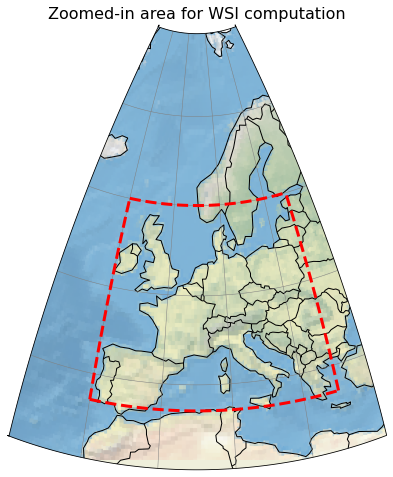

In [100]:
fig = plt.figure(figsize=(11, 8))

ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Zoomed-in area for WSI computation', fontsize = 16)
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.plot([lonW_zoom]*len(lat_zoom), lat_zoom, transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot([lonE_zoom]*len(lat_zoom), lat_zoom, transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot(lon_zoom, [latN_zoom]*len(lon_zoom), transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot(lon_zoom, [latS_zoom]*len(lon_zoom), transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)

ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', linestyle='-')
plt.show()

=================================================================================================================

Selecting data over this chosen area

In [133]:
ws_zoom = ws.sel(longitude = lon_zoom, latitude = lat_zoom).ws.fillna(0).to_dataset()

### Definition of WSI (over land) and first visualisations

#### WSI using a simple spatial mean

Computing spatial average over land for each timestep ie. comuting Wind Speed Index (WSI) weighted by $\sqrt{cos(lat)}$ to prevent gridpoint stretch biais.

In [137]:
wgts = np.sqrt(np.cos(np.deg2rad(ws_zoom.latitude)))

In [138]:
ws_zoom_weighted = ws_zoom.weighted(wgts)

In [139]:
ws_index = ws_zoom_weighted.mean(dim = ['longitude','latitude'])

=================================================================================================================

Daily climatological mean of WSI over the full period (1980-2019)

In [140]:
ws_index_dmean = ws_index.groupby('time.dayofyear').mean('time')

=================================================================================================================

Computing a 30-day rolling mean of the previously computed WSI daily mean ie. a smooth daily climatology of WSI

In [141]:
ws_index_day_mean = xr.concat([
    ws_index_dmean.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index_dmean.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index_dmean.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

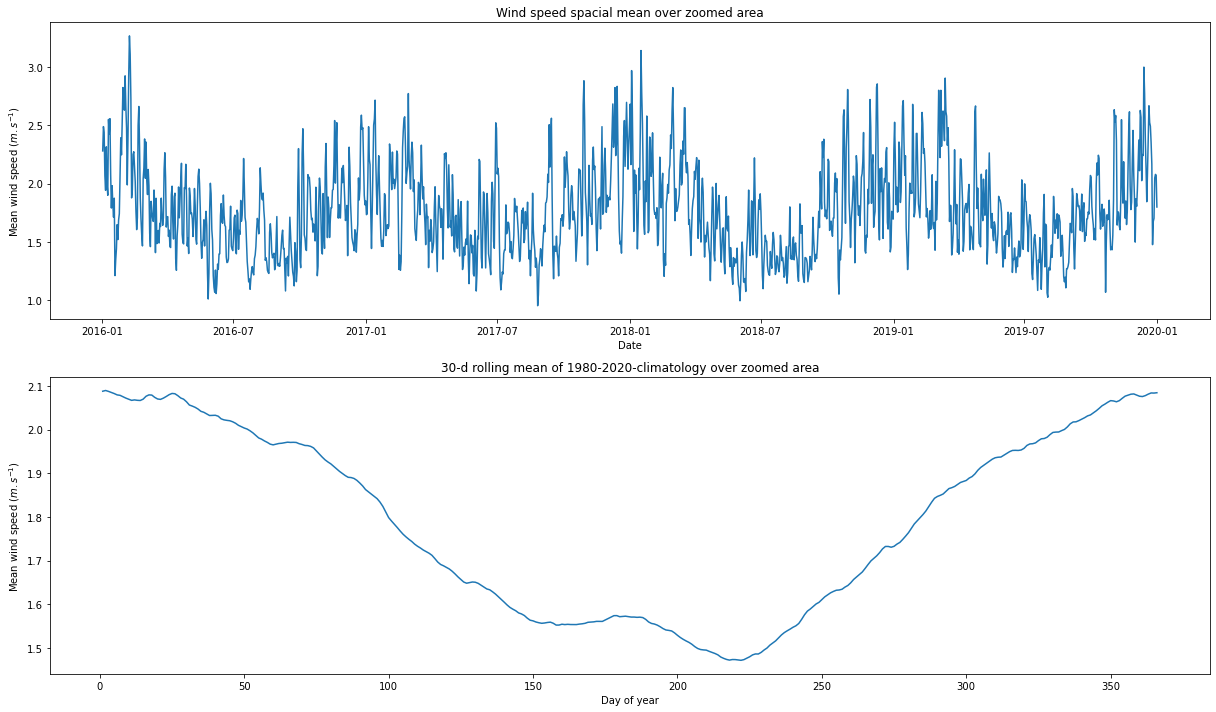

In [142]:
fig = plt.figure(figsize=(17, 10))

ax = fig.add_subplot(2, 1, 1)
ax.set_title('Wind speed spacial mean over zoomed area')
ax.plot(ws_index.time.values[-365*4:], ws_index.ws[-365*4:])
ax.set_xlabel('Date')
ax.set_ylabel('Mean wind speed ($m.s^{-1}$)')

ax = fig.add_subplot(2, 1, 2)
ax.set_title('30-d rolling mean of 1980-2020-climatology over zoomed area')
ax.plot(ws_index_day_mean.dayofyear, ws_index_day_mean)
ax.set_xlabel('Day of year')
ax.set_ylabel('Mean wind speed ($m.s^{-1}$)')

plt.tight_layout()
plt.show()

##### Comments
High frequence (daily) variability and seasonnal cycle appear, isolation of the seasonnal cycle with a 30-d rolling mean.

=================================================================================================================

Let's take a look on high frequence variability by substracting the seasonnal cycle.

In [143]:
ws_index_danom = ws_index.ws.groupby('time.dayofyear') - ws_index_day_mean

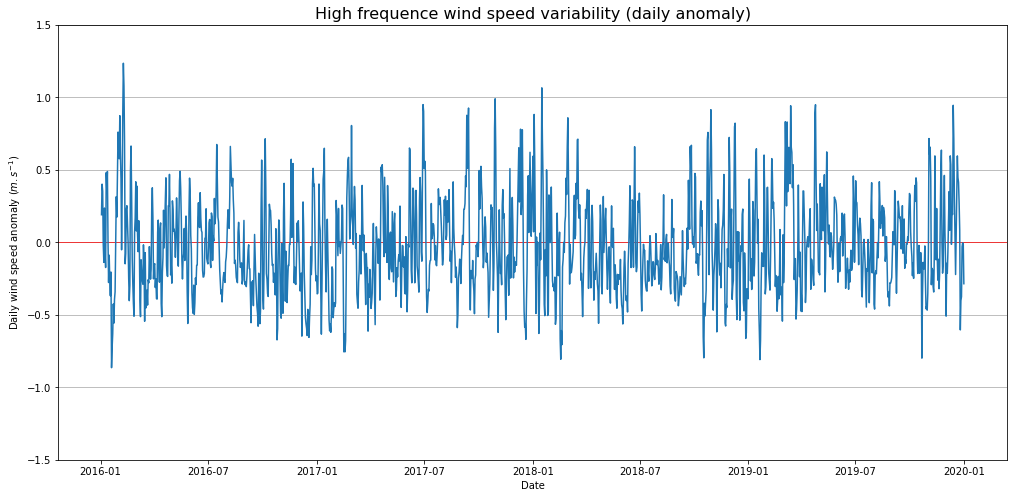

In [146]:
fig = plt.figure(figsize=(17, 8))
ws_index_danom_zoom = ws_index_danom[-365*4:]

ax = fig.add_subplot(1, 1, 1)
ax.set_title('High frequence wind speed variability (daily anomaly)', fontsize = 16)
ax.set_xlabel('Date')
ax.set_ylabel('Daily wind speed anomaly ($m.s^{-1}$)')
ax.set_ylim(-1.5,1.5)
ax.plot(ws_index_danom_zoom.time.values, ws_index_danom_zoom, zorder = 3)
ax.grid(axis = 'y', zorder = 1)
ax.axhline(0, color='red', lw = 0.7, zorder = 2)
plt.show()

##### Comments
More variability during winter ?

=================================================================================================================

Verificaton with seasonnal and daily standard deviation $\sigma$

In [147]:
ws_index_sstd = ws_index_danom.groupby('time.season').std('time')

In [148]:
ws_index_dstd = ws_index.groupby('time.dayofyear').std('time')

Computing 30-d rolling mean

In [149]:
ws_index_day_std = xr.concat([
    ws_index_dstd.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index_dstd.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index_dstd.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

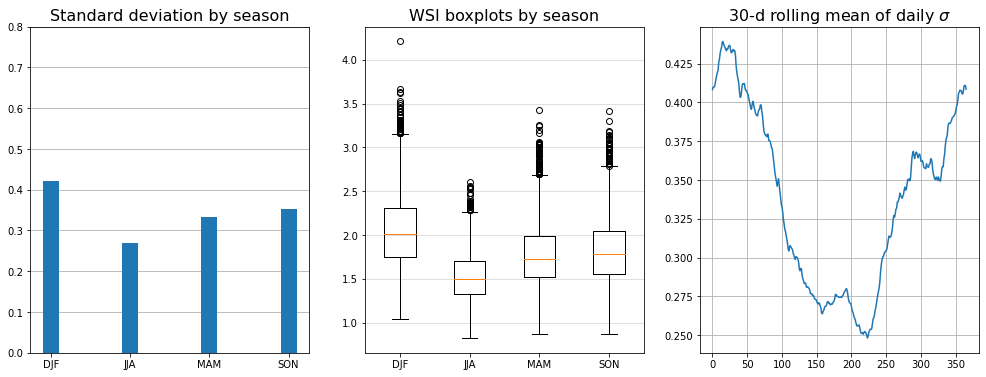

In [151]:
fig = plt.figure(figsize=(17, 6))

ax = fig.add_subplot(1, 3, 1)
ax.set_title('Standard deviation by season', fontsize = 16)
ax.bar(ws_index_sstd.season, ws_index_sstd.values, width = 0.2, zorder = 2)
ax.grid(axis = 'y',zorder = 1)
ax.set_ylim(0,0.8)

ax = fig.add_subplot(1, 3, 2)
ax.set_title('WSI boxplots by season', fontsize = 16)
test=[]
for season in ws_index_sstd.season.values :
    test.append(ws_index.ws.groupby('time.season')[season])
ax.boxplot(test, labels = ws_index_sstd.season.values)
ax.grid(axis = 'y', alpha = 0.5)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('30-d rolling mean of daily $\sigma$', fontsize = 16)
ax.plot(ws_index_day_std)
ax.grid()

plt.show()

In [152]:
ws_index_dmax = ws_index.groupby('time.dayofyear').max('time')
ws_index_dmin = ws_index.groupby('time.dayofyear').min('time')

In [153]:
ws_index_day_max = xr.concat([
    ws_index_dmax.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index_dmax.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index_dmax.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')
ws_index_day_min = xr.concat([
    ws_index_dmin.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index_dmin.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index_dmin.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [154]:
ws_index_day_mean = ws_index_day_mean.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')

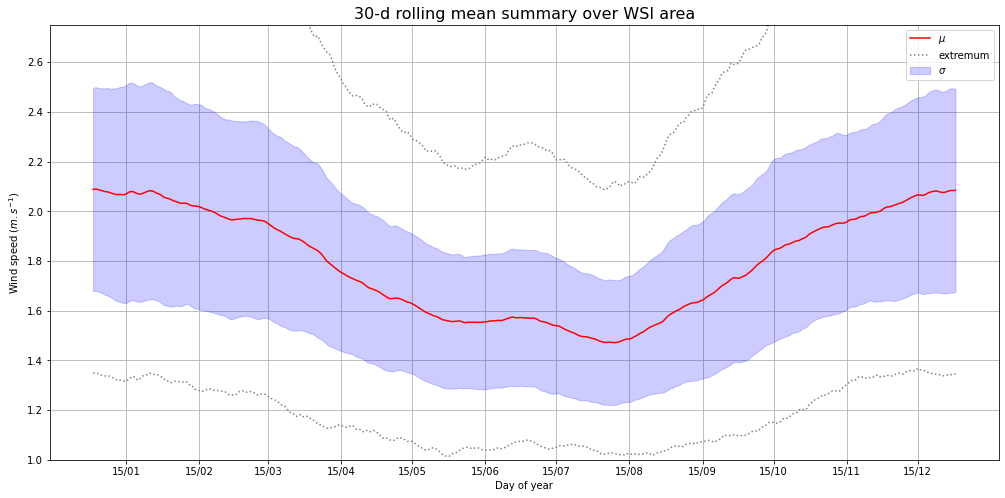

In [159]:
fig = plt.figure(figsize=(17, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('30-d rolling mean summary over WSI area', fontsize = 16)
ax.plot(ws_index_day_mean, color = 'red', zorder = 3, label = '$\mu$')
ax.plot(ws_index_day_max, color = 'gray', ls = ':', label = 'extremum')
ax.plot(ws_index_day_min, color = 'gray', ls = ':')
ax.fill_between(ws_index_day_mean.date, ws_index_day_mean-ws_index_day_std, ws_index_day_mean+ws_index_day_std, color = 'blue', alpha = 0.2, zorder = 2, label = '$\sigma$')
ax.grid(zorder = 1)
ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_ylabel('Wind speed ($m.s^{-1}$)')
ax.set_ylim(1,2.75)
ax.legend()

plt.show()

+ Idea to define WSI :
    + simple spatial mean over land could be replaced by a <b>wind-turbine-density-weighted-mean</b> but
        + need for data (seems that no free dataset is available)
        + excludes potential future windfarm location and high potential power density areas
    + idea of wind outage detection using WSI :
        + catching statisiticaly weak anomaly (like -1.5 or -2 $\sigma$) that happen during usually weak wind period (low mean)
        + using a simple wind speed theshold
            + statistically defined ?
            + treshold of significant power output ? 3$m.s^{-1}$ -> integrated over large area : does it make sense ?

### Detection using empirical WSI treshold

#### Simple spatial mean

In [160]:
WSI = ws_index.ws

Treshold choice : $min(\mu-\sigma) \approx 1.2 m.s^{-1}$

In [161]:
treshold = 1.2

In [162]:
WSI_u2 = WSI.where(WSI < treshold, drop = True)
print(f'{len(WSI_u2)} days with WSI < {treshold}m/s on {len(WSI)} days available on data ({round(len(WSI_u2)/len(WSI)*100,2)}%)')

620 days with WSI < 1.2m/s on 14975 days available on data (4.14%)


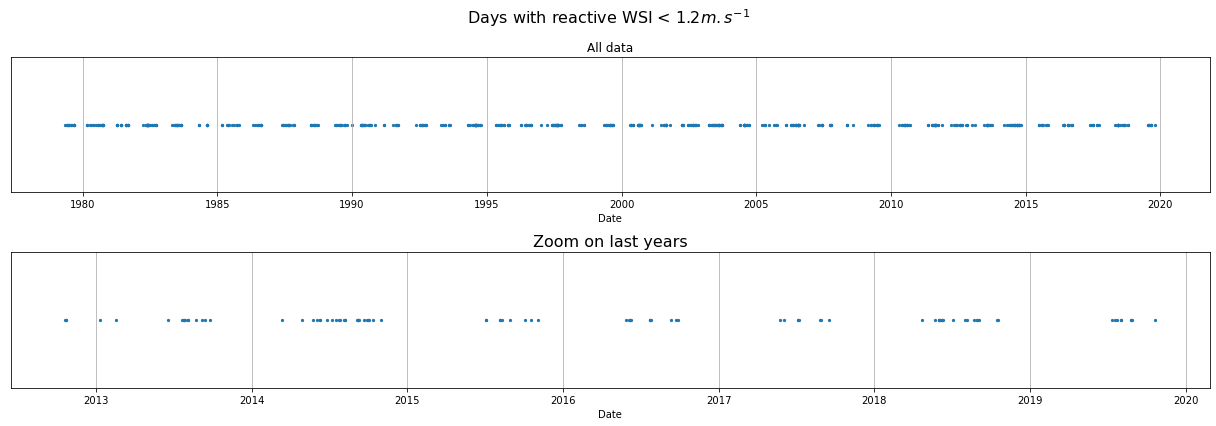

In [163]:
fig = plt.figure(figsize=(17, 6))

plt.suptitle(f'Days with reactive WSI < {treshold}$m.s^{{-1}}$', fontsize = 16)
ax = fig.add_subplot(2, 1, 1)
ax.set_title('All data')
ax.set_xlabel('Date')
ax.set_yticks([])
ax.grid(axis = 'x')
ax.scatter(WSI_u2.time.values, [1]*len(WSI_u2), s = 5)

ax = fig.add_subplot(2, 1, 2)
ax.set_title('Zoom on last years', fontsize = 16)
ax.set_xlabel('Date')
ax.set_yticks([])
ax.grid(axis = 'x')
ax.scatter(WSI_u2.time.values[-100:], [1]*len(WSI_u2[-100:]), s = 5)

plt.tight_layout()
plt.show()

In [164]:
WSI_u2_density = WSI.where(WSI < treshold).groupby('time.dayofyear').count()

In [165]:
WSI_u2_smooth_density = xr.concat([
    WSI_u2_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    WSI_u2_density.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    WSI_u2_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [166]:
WSI_u2_smooth_density = WSI_u2_smooth_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')
WSI_u2_density = WSI_u2_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')

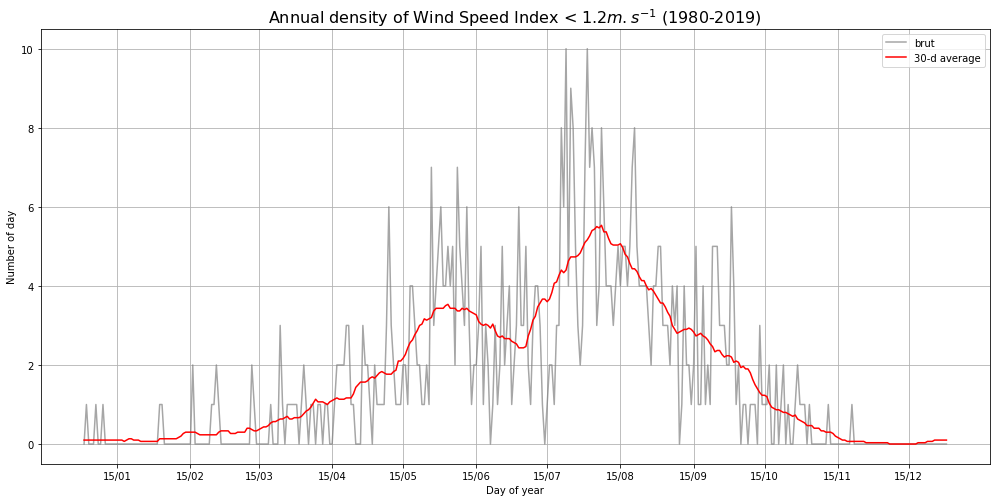

In [167]:
fig = plt.figure(figsize=(17, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Annual density of Wind Speed Index < {treshold}$m.s^{{-1}}$ (1980-2019)', fontsize = 16)
ax.plot(WSI_u2_density.date.values, WSI_u2_density, color = 'gray', alpha = 0.7, zorder = 2, label = 'brut')
ax.plot(WSI_u2_density.date.values, WSI_u2_smooth_density, color = 'red', zorder = 3, label = '30-d average')
ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_ylabel('Number of day')
ax.grid(zorder = 1)
ax.legend()
plt.show()

#### One-day outage filtration

In [168]:
WSI_u2_filter = WSI_u2

In [169]:
drop_count = 0
for index, WO_day in enumerate(WSI_u2.time.dt.date.values) :
    try :
        if not (WO_day.toordinal() - 1 == WSI_u2.time.dt.date.values[index - 1].toordinal() or WO_day.toordinal() + 1 == WSI_u2.time.dt.date.values[index + 1].toordinal()) :
            WSI_u2_filter = WSI_u2_filter.drop_sel(time = str(WSI_u2[index].time.values))
            print(f'Dropping {WSI_u2[index].time.values}', end = '\r')
            drop_count+=1
    except IndexError :
        pass #start and end raise this error
print(f'{drop_count} days dropped                      ')

196 days dropped                      


In [170]:
blank = WSI.where(WSI == False).groupby('time.dayofyear').count().drop_sel(dayofyear = WSI_u2_filter.groupby('time.dayofyear').count().dayofyear.values)

In [171]:
WSI_u2_filter_density = blank.combine_first(WSI_u2_filter.groupby('time.dayofyear').count())

In [172]:
WSI_u2_filter_smooth_density = xr.concat([
    WSI_u2_filter_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    WSI_u2_filter_density.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    WSI_u2_filter_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [173]:
WSI_u2_filter_smooth_density = WSI_u2_filter_smooth_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')
WSI_u2_filter_density = WSI_u2_filter_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')

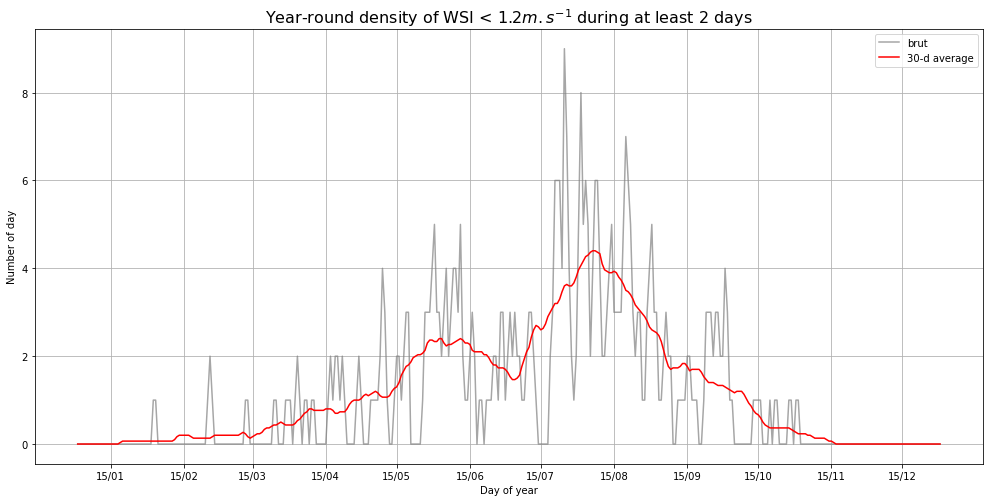

In [174]:
fig = plt.figure(figsize=(17, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_title(f'Year-round density of WSI < {treshold}$m.s^{{-1}}$ during at least 2 days', fontsize = 16)
ax.plot(WSI_u2_filter_density.date.values, WSI_u2_filter_density, color = 'gray', alpha = 0.7, zorder = 2, label = 'brut')
ax.plot(WSI_u2_filter_density.date.values, WSI_u2_filter_smooth_density, color = 'red', zorder = 3, label = '30-d average')
ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_ylabel('Number of day')
ax.grid(zorder = 1)
ax.legend()
plt.show()